# Test pytorch optimizers

In [65]:
import torch
import xitorch as xt
from xitorch.optimize import minimize, rootfinder

class LO(xt.LinearOperator):
    def __init__(self, a, size):
        super().__init__(shape=(size, size), is_hermitian=True)
        self.a = a

    def _mv(self, x):
        return self.a @ x

    def _getparamnames(self, prefix=""):
        return [prefix+"a"]

n = 2
a = 0
def func(x):
    # m = torch.concat([x[None], torch.zeros((n - 1, n))])
    # m = m + m.T
    m = x * torch.tensor([[0, 1.], [1., 0]])
    h = LO(m, n)

    v = xt.linalg.symeig(h, 1)
    return v[0][0]**4

# # set up the parameters and the initial guess
# A = torch.tensor([[1.1, 0.4], [0.3, 0.8]]).requires_grad_()
# x0 = torch.tensor([0.5, 0.5, 0.5], requires_grad=True)  # zeros as the initial guess

x0 = torch.tensor([0.5], requires_grad=True)  # zeros as the initial guess
x = minimize(func, x0)
x
# # finding a root
# yroot = rootfinder(func, x0, params=(A,))

# # calculate the derivatives
# dydA, = torch.autograd.grad(yroot.sum(), (A,), create_graph=True)
# grad2A, = torch.autograd.grad(dydA.sum(), (A,), create_graph=True)

tensor([3.5576e-06], grad_fn=<_RootFinderBackward>)

### Order & memory read test

In [23]:
import torch

a = torch.Tensor([1, 2, 3]).requires_grad_()
b = torch.Tensor([4, 5]).requires_grad_()
c = torch.stack([a, a])
print(a[0])
print([a, b])
print(a[[2, 1]])
print(c)
print(a * (a != 1))
print(torch.max(a))
print(abs(-a))
print([a[i] for i in range(3)])
a[0] = 10

tensor(1., grad_fn=<SelectBackward0>)
[tensor([1., 2., 3.], requires_grad=True), tensor([4., 5.], requires_grad=True)]
tensor([3., 2.], grad_fn=<IndexBackward0>)
tensor([[1., 2., 3.],
        [1., 2., 3.]], grad_fn=<StackBackward0>)
tensor([0., 2., 3.], grad_fn=<MulBackward0>)
tensor(3., grad_fn=<MaxBackward1>)
tensor([1., 2., 3.], grad_fn=<AbsBackward0>)
[tensor(1., grad_fn=<SelectBackward0>), tensor(2., grad_fn=<SelectBackward0>), tensor(3., grad_fn=<SelectBackward0>)]


RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

Cannot assign value to a leaf tensor.

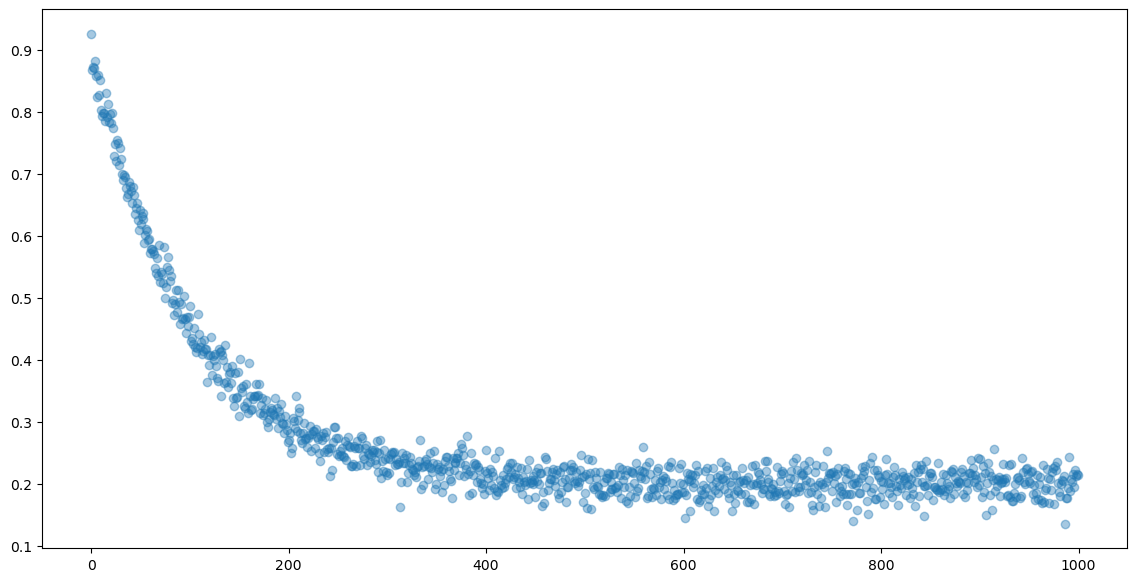

In [38]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from copy import copy

n = 1000
noise = torch.Tensor(np.random.normal(0, 0.02, size=n))
x = torch.arange(n)
a, k, b = 0.7, .01, 0.2
y = a * np.exp(-k * x) + b + noise
plt.figure(figsize=(14, 7))
plt.scatter(x, y, alpha=0.4)

In [12]:
class Model(nn.Module):
    """
    Custom Pytorch model for gradient optimization.
    """

    def __init__(self):

        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)

    def forward(self, X):
        """
        Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        a, k, b = self.weights
        return a * torch.exp(-k * X) + b


def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        preds = model(x)
        loss = F.mse_loss(preds, y).sqrt()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.detach().numpy())
    return losses


Parameter containing:
tensor([0.6772, 0.0097, 0.2002], requires_grad=True)


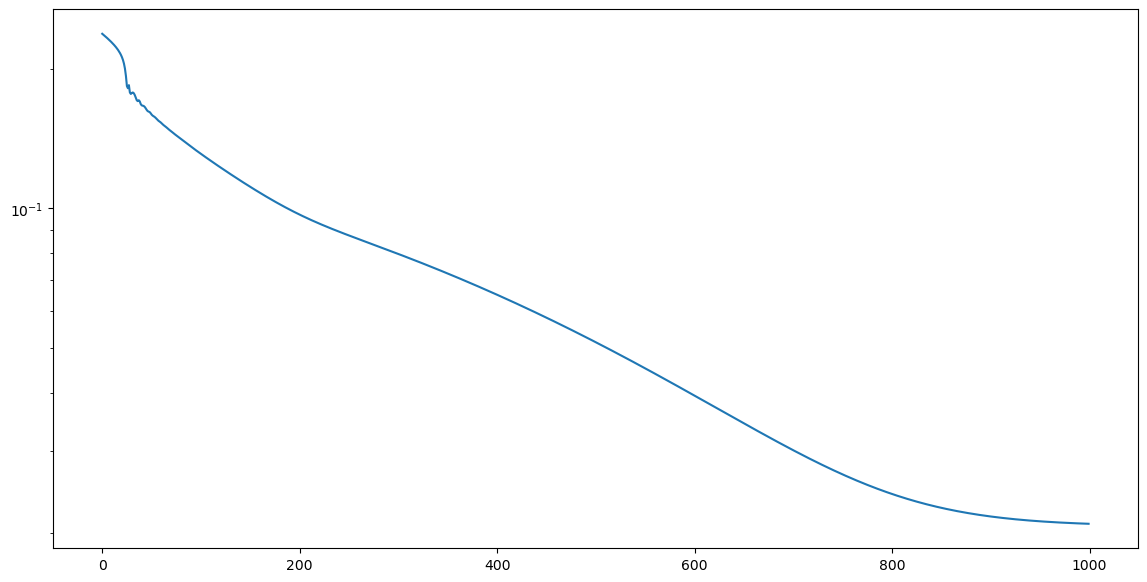

In [14]:
# instantiate model
m = Model()
# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)
plt.figure(figsize=(14, 7))
plt.plot(losses)
plt.yscale("log")
print(m.weights)